In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
import sys,os
sys.path.append('../../')
from gammaPAC.gammaPAC import *
from gammaPAC.generalPAC import *
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
np.random.seed(0)

In [7]:
dataDir = '../data/'
subj_num = 1
fs = 125

methodsAR = ['ica','eogReg','raw']
methodAR = methodsAR[1]
start = 2
stop = 12

#load EEG data
dataEEG = np.load(dataDir + f'subject{subj_num}_EEG.npy')

dataEEG = dataEEG*1e6


#load EGG data
matEGG = sp.io.loadmat(dataDir + f'subject{subj_num}_EGG.mat')
dataEGG = np.squeeze(matEGG['bestEGG'])
dataEGG = sp.signal.decimate(dataEGG, 2)
dataEGG = dataEGG[start*60*fs:stop*60*fs]

channel_names = [f'E{i}' for i in range(1,129)]
info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types=['eeg']*(dataEEG.shape[0]-1))
info.set_montage('GSN-HydroCel-128');

In [8]:
#function to plot PAC topoplot
def plot_PAC_topoplot(values,info,fig_name,ax_title = 'Z-scored MI',fsave = True,vlim = (-5,5),reduce = True):
  if reduce:
    eeg_indices = mne.pick_types(info, meg=False, eeg=True)
    eeg_indices = np.delete(eeg_indices,[47,48,112,118,125,126])
    info = mne.pick_info(info, eeg_indices)
    try:
      values = np.delete(values,[47,48,112,118,125,126,128])  #delete these only for visualization (these channels are way at edge of head)
    except:
      values = np.delete(values,[47,48,112,118,125,126])

  

  fig,ax1 = plt.subplots(ncols=1)
  im,cn = mne.viz.plot_topomap(values,info,ch_type = 'eeg',
                              image_interp = 'cubic',extrapolate='local',size = 5,cmap = 'jet',axes=ax1,show=False,
                              vlim = vlim)

  ax_x_start = 0.95
  ax_x_width = 0.04
  ax_y_start = 0.1
  ax_y_height = 0.9
  cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
  clb = fig.colorbar(im, cax=cbar_ax)
  clb.ax.set_title(ax_title) # title on top of colorbar
  #set colorbar limits
  fig.subplots_adjust(wspace=.05)
  if fsave:
    #lgd = ax1.legend()
    #plt.savefig(fig_name,bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.savefig(fig_name,bbox_inches='tight')

## pac data

In [9]:
def compute_pvals(values,surrogates):
    pvals = np.zeros((values.shape[0],))
    for i in range(values.shape[0]):
        if np.isnan(values[i]) or np.isnan(surrogates[i]).all():
            pvals[i] = 1#np.nan
        else:
            pvals[i] = np.sum(surrogates[i]>values[i])/surrogates[i].shape[0]
    return pvals

def holm_procedure(pvals,alpha=0.05,fPlot = True):
    n = len(pvals)
    sort_idx = np.argsort(pvals)
    pvals_sorted = pvals[sort_idx]

    pvals_holm = np.zeros((n,))
    for i in range(n):
        pvals_holm[i] = min(pvals_sorted[i]*(n-i),1)
    
    #step-down procedure to find the largest k such that all p(k) for 1,...,k <= alpha
    k = 0
    for i in range(n):
        if pvals_sorted[i] <= alpha/(n-i):
            k = i
        else:
            break
    #print(f'k = {k+1}')
    
    if fPlot:
        plt.scatter(np.arange(1,n+1),pvals_holm,s = 1,marker='*')
        plt.plot(np.arange(1,n+1),alpha*np.ones((n,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        #plt.scatter(np.arange(1,n+1),pvals_sorted,s = 1,marker='*')
        #plt.plot(np.arange(1,n+1),alpha*np.arange(1,n+1)/n,'--',color = 'tab:orange')
        plt.axvline(k+1,linestyle='--',color='tab:red',label = f'crit-value = {k+1}')
        plt.xlabel('Sorted index')
        plt.ylabel('Holm adjusted p-value')
        plt.title('Holm Procedure')
        plt.legend(loc = 'lower right')

    return pvals_holm,sort_idx,k

def bh_procedure(pvals,alpha=0.05,fPlot = True):
    n = len(pvals)
    sort_idx = np.argsort(pvals)
    pvals_sorted = pvals[sort_idx]

    pvals_bh = np.zeros((n,))
    for i in range(n):
        pvals_bh[i] = min(pvals_sorted[i]*n/(i+1),1)
    
    #step-up procedure to find the largest k such that p(k) <= alpha*k/n
    k = -1
    for i in range(n):
        if pvals_sorted[i] <= alpha*(i+1)/n:
            k = i
    #print(f'k = {k+1}')
    
    if fPlot:
        plt.scatter(np.arange(1,n+1),pvals_bh,s = 1,marker='*')
        plt.plot(np.arange(1,n+1),alpha*np.ones((n,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        #plt.scatter(np.arange(1,n+1),pvals_sorted,s = 1,marker='*')
        #plt.plot(np.arange(1,n+1),alpha*np.arange(1,n+1)/n,'--',color = 'tab:orange')
        plt.axvline(k+1,linestyle='--',color='tab:red',label = f'crit-value = {k+1}')
        plt.xlabel('Sorted index')
        plt.ylabel('BH adjusted p-value')
        plt.title('Benjamini-Hochberg Procedure')
        plt.legend(loc = 'lower right')

    return pvals_bh,sort_idx,k

def by_procedure(pvals,alpha=0.05,fPlot = True):
    n = len(pvals)
    Sn = np.sum(1/np.arange(1,n+1))
    sort_idx = np.argsort(pvals)
    pvals_sorted = pvals[sort_idx]

    pvals_by = np.zeros((n,))
    for i in range(n):
        pvals_by[i] = min(pvals_sorted[i]*n*Sn/(i+1),1)
    
    #step-up procedure to find the largest k such that p(k) <= alpha*k/n
    k = -1
    for i in range(n):
        if pvals_sorted[i] <= alpha*(i+1)/(n*Sn):
            k = i
    #print(f'k = {k+1}')
    
    if fPlot:
        plt.scatter(np.arange(1,n+1),pvals_by,s = 1,marker='*')
        plt.plot(np.arange(1,n+1),alpha*np.ones((n,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        #plt.scatter(np.arange(1,n+1),pvals_sorted,s = 1,marker='*')
        #plt.plot(np.arange(1,n+1),alpha*np.arange(1,n+1)/n,'--',color = 'tab:orange')
        plt.axvline(k+1,linestyle='--',color='tab:red',label = f'crit-value = {k+1}')
        plt.xlabel('Sorted index')
        plt.ylabel('BY adjusted p-value')
        plt.title('Benjamini-Yekutieli Procedure')
        plt.legend(loc = 'lower right')

    return pvals_by,sort_idx,k

def resort(data,sort_idx):
    new_data = np.zeros(data.shape)
    for i,idx in enumerate(sort_idx):
        new_data[idx] = data[i]
    return new_data

In [11]:
## load data
subjs = [1,2]
mat_files = []

for subj_num in subjs:
    subj = f'subject{subj_num}'
    mat = sp.io.loadmat('../data/' + f'{subj}_PAC_MI.mat')
    mat_files.append(mat)
mat.keys()
pac_methods = ['mi','pac']

In [12]:
#compute p-values for each subject and method
pvals_list = []
for i,mat in enumerate(mat_files):
    pac_method = pac_methods[i]
    if pac_method == 'mi':
        values = mat['mi_values'].flatten()
        surrogates = mat['mi_surrogates']
    elif pac_method == 'pac':
        values = mat['pac_values'].flatten()
        surrogates = mat['pac_surrogates']
    pvals_list.append(compute_pvals(values[:128],surrogates[:128]))


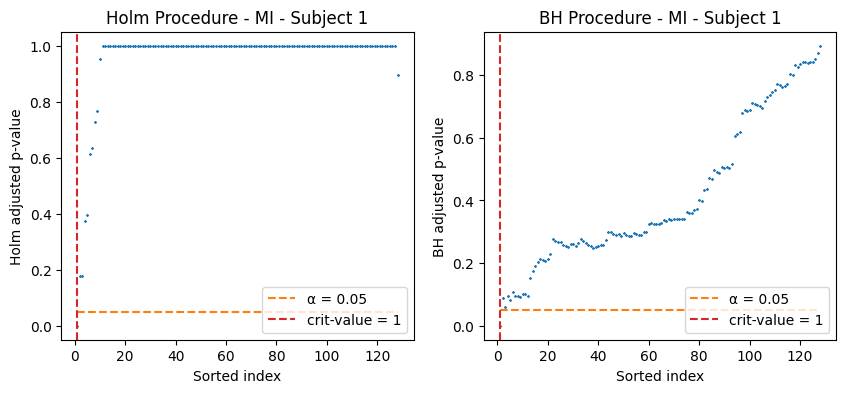

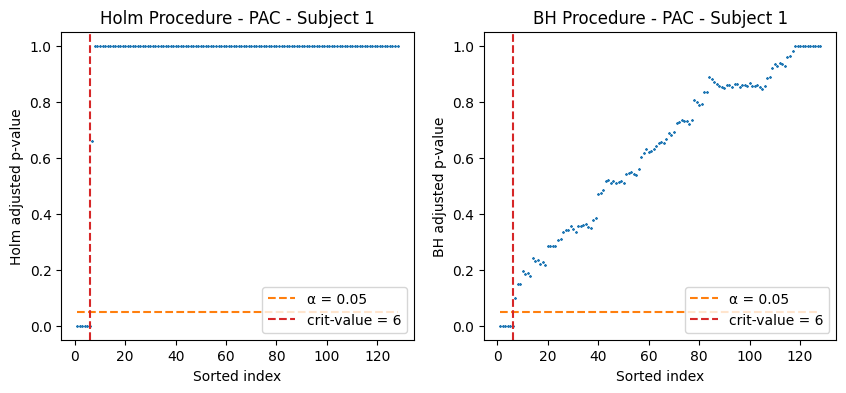

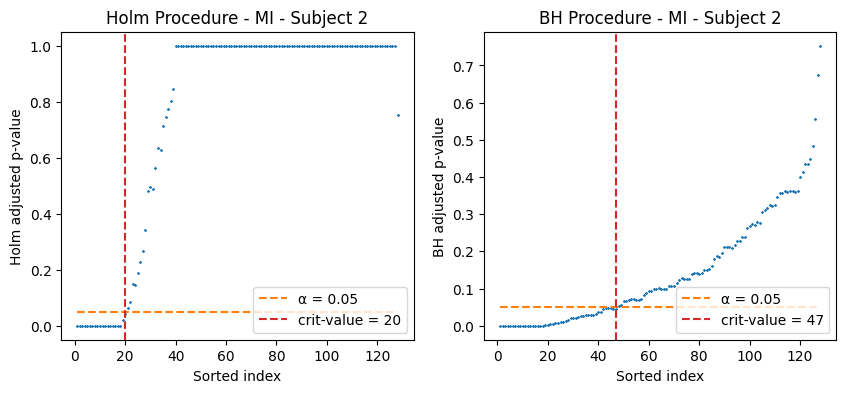

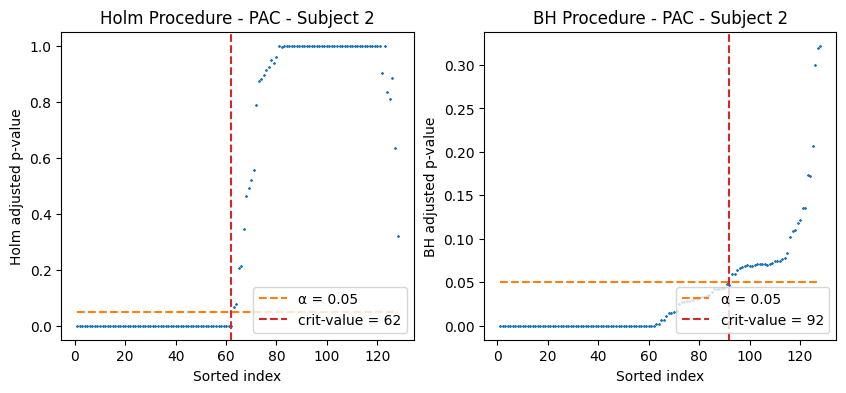

In [13]:
## plot both bh and holm procedures for each subject and method
alpha = 0.05
bh_idces = []
holm_idces = []
pvals_bh_list = []
pvals_holm_list = []

for i,mat in enumerate(mat_files):
    subj_num = i+1
    for m in pac_methods:
        if m == 'mi':
            values = mat['mi_values'].flatten()
            surrogates = mat['mi_surrogates']
        elif m == 'pac':
            values = mat['pac_values'].flatten()
            surrogates = mat['pac_surrogates']
        pvals = compute_pvals(values[:128],surrogates[:128])
        pvals_holm,sort_idx_holm,k_holm = holm_procedure(pvals,alpha=alpha,fPlot = False)
        pvals_bh,sort_idx_bh,k_bh = bh_procedure(pvals,alpha=alpha,fPlot = False)

        bh_idces.append(sort_idx_bh)
        holm_idces.append(sort_idx_holm)
        pvals_bh_list.append(pvals_bh)
        pvals_holm_list.append(pvals_holm)

        fig,ax = plt.subplots(ncols=2,figsize=(10,4))
        ax[0].scatter(np.arange(1,129),pvals_holm,s = 1,marker='*')
        ax[0].plot(np.arange(1,129),alpha*np.ones((128,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        ax[0].axvline(k_holm+1,linestyle='--',color='tab:red',label = f'crit-value = {k_holm+1}')
        ax[0].set_xlabel('Sorted index')
        ax[0].set_ylabel('Holm adjusted p-value')
        ax[0].set_title(f'Holm Procedure - {m.upper()} - Subject {subj_num}')
        ax[0].legend(loc = 'lower right')

        ax[1].scatter(np.arange(1,129),pvals_bh,s = 1,marker='*')
        ax[1].plot(np.arange(1,129),alpha*np.ones((128,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        ax[1].axvline(k_bh+1,linestyle='--',color='tab:red',label = f'crit-value = {k_bh+1}')
        ax[1].set_xlabel('Sorted index')
        ax[1].set_ylabel('BH adjusted p-value')
        ax[1].set_title(f'BH Procedure - {m.upper()} - Subject {subj_num}')
        ax[1].legend(loc = 'lower right')

        plt.savefig(f'{subj_num+11}_{m}_multiple_comparisons.svg',bbox_inches='tight')



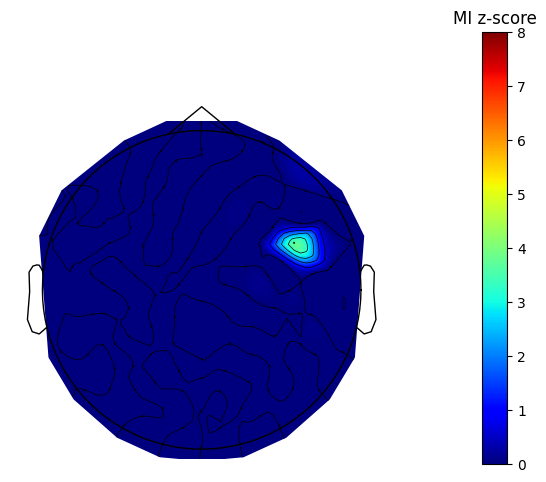

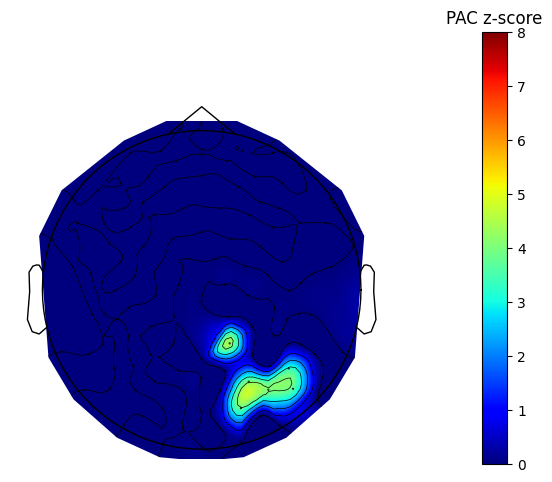

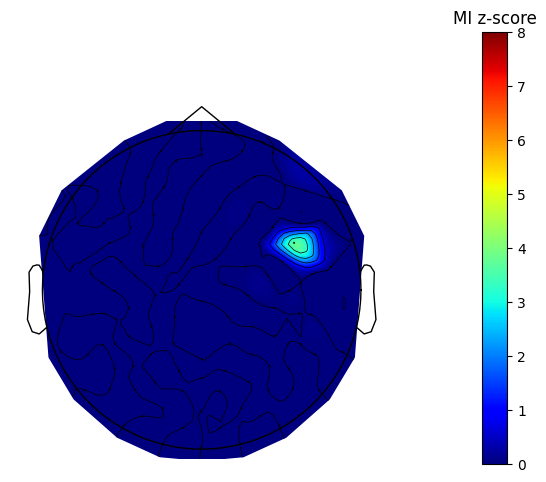

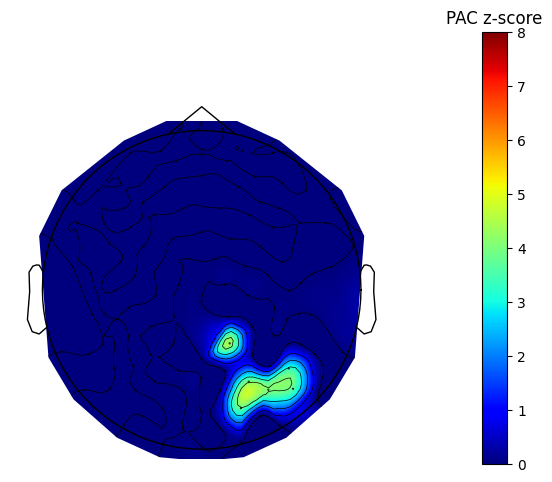

In [16]:
s = 0 #subject number to plot (-1 because of 0 indexing)
mat=mat_files[s]

plotidx1 = resort(pvals_holm_list[2*s],holm_idces[2*s])<.05
plotidx2 = resort(pvals_holm_list[2*s+1],holm_idces[2*s+1])<.05

plot_score1 = mat['mi_z_scores'].flatten()[:128]
plot_score1[~plotidx1] = 0
plot_score2 = mat['pac_z_scores'].flatten()[:128]
plot_score2[~plotidx2] = 0

plot_PAC_topoplot(plot_score1,info,f"patient{s+12}_mi_holm_pval_topo.svg",ax_title = 'MI z-score',fsave = False,vlim = (0,8),reduce = True)
plot_PAC_topoplot(plot_score2,info,f"patient{s+12}_pac_holm_pval_topo.svg",ax_title = "PAC z-score",fsave = False,vlim = (0,8),reduce = True)

plotidx1 = resort(pvals_bh_list[2*s],bh_idces[2*s])<.05
plotidx2 = resort(pvals_bh_list[2*s+1],bh_idces[2*s+1])<.05

plot_score1 = mat['mi_z_scores'].flatten()[:128]
plot_score1[~plotidx1] = 0
plot_score2 = mat['pac_z_scores'].flatten()[:128]
plot_score2[~plotidx2] = 0

plot_PAC_topoplot(plot_score1,info,f"patient{s+12}_mi_bh_pval_topo.svg",ax_title = 'MI z-score',fsave = False,vlim = (0,8),reduce = True)
plot_PAC_topoplot(plot_score2,info,f"patient{s+12}_pac_bh_pval_topo.svg",ax_title = "PAC z-score",fsave = False,vlim = (0,8),reduce = True)

## Comodulograms

LFP_HFO_comodulogram_MI.npy
LFP_HFO_comodulogram_gammaPAC.npy
LFP_HG_comodulogram_MI.npy
LFP_HG_comodulogram_gammaPAC.npy
surrogate_comodulograms.mat

In [18]:
#load comodulogram data
comod_dir = '../data'


hfo_pac_comod = np.load(comod_dir + '/LFP_HFO_comodulogram_gammaPAC.npy')
hfo_mi_comod = np.load(comod_dir + '/LFP_HFO_comodulogram_MI.npy')
hg_pac_comod = np.load(comod_dir + '/LFP_HG_comodulogram_gammaPAC.npy')
hg_mi_comod = np.load(comod_dir + '/LFP_HG_comodulogram_MI.npy')

surrogate_comodulograms = sp.io.loadmat(comod_dir + '/surrogate_comodulograms.mat')
comods = [hg_mi_comod,hg_pac_comod,hfo_mi_comod,hfo_pac_comod]
keys = ['MI_HG_surrs', 'PAC_HG_surrs', 'MI_HFO_surrs', 'PAC_HFO_surrs']

names = ['High Gamma MI','High Gamma PAC','HFO MI','HFO PAC']

In [26]:
#just defined to help plot the heatmaps
lband = [.5,20.5]
hbands = [[.5,100.5],[.5,150.5]]

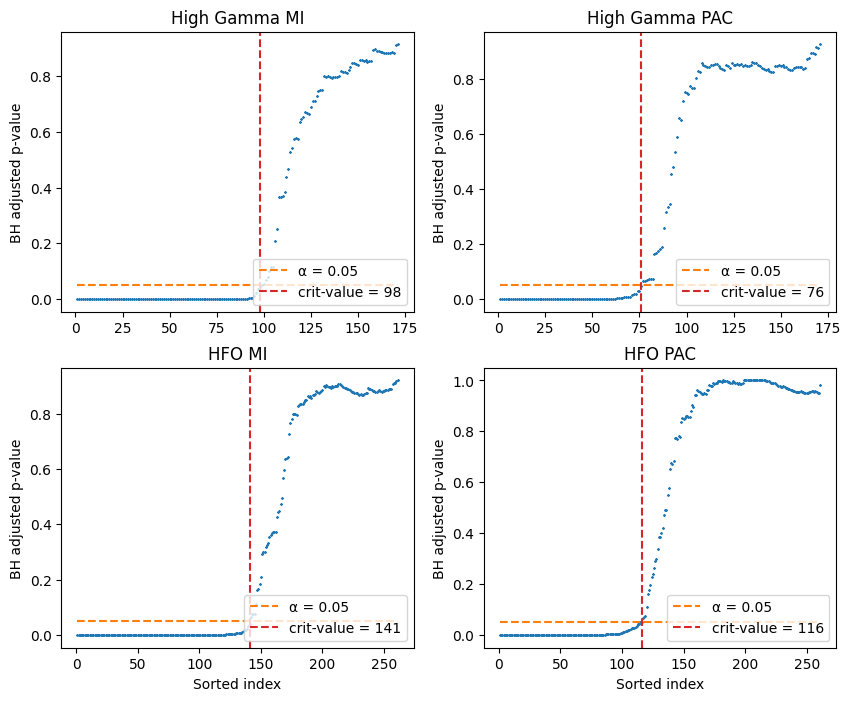

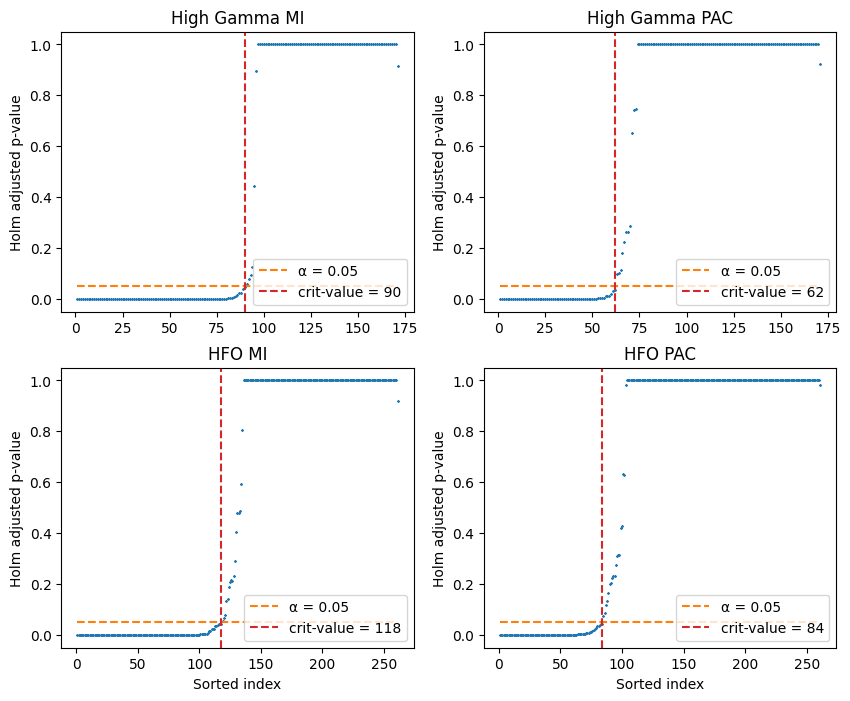

In [27]:
plt.subplots(2,2,figsize=(10,8))

#plot all comodulogram bh procedure
for i in range(4):
    plt.subplot(2,2,i+1)
    pvals_bh, bh_idx, k = bh_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = True)
    plt.title(f'{names[i]}')
    if i == 0 or i ==1:
        plt.xlabel('')

#plt.savefig('../Figures/comod_bh_pvals.svg')

# do this for the holm procedure
plt.subplots(2,2,figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    pvals_holm, holm_idx, k = holm_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = True)
    plt.title(f'{names[i]}')
    if i == 0 or i ==1:
        plt.xlabel('')
    #ax[i].imshow(comod[i])
#plt.savefig('../Figures/comod_holm_pvals.svg')

High Gamma MI: 98 significant points
High Gamma PAC: 76 significant points
HFO MI: 141 significant points
HFO PAC: 116 significant points
High Gamma MI: 90 significant points
High Gamma PAC: 62 significant points
HFO MI: 118 significant points
HFO PAC: 84 significant points


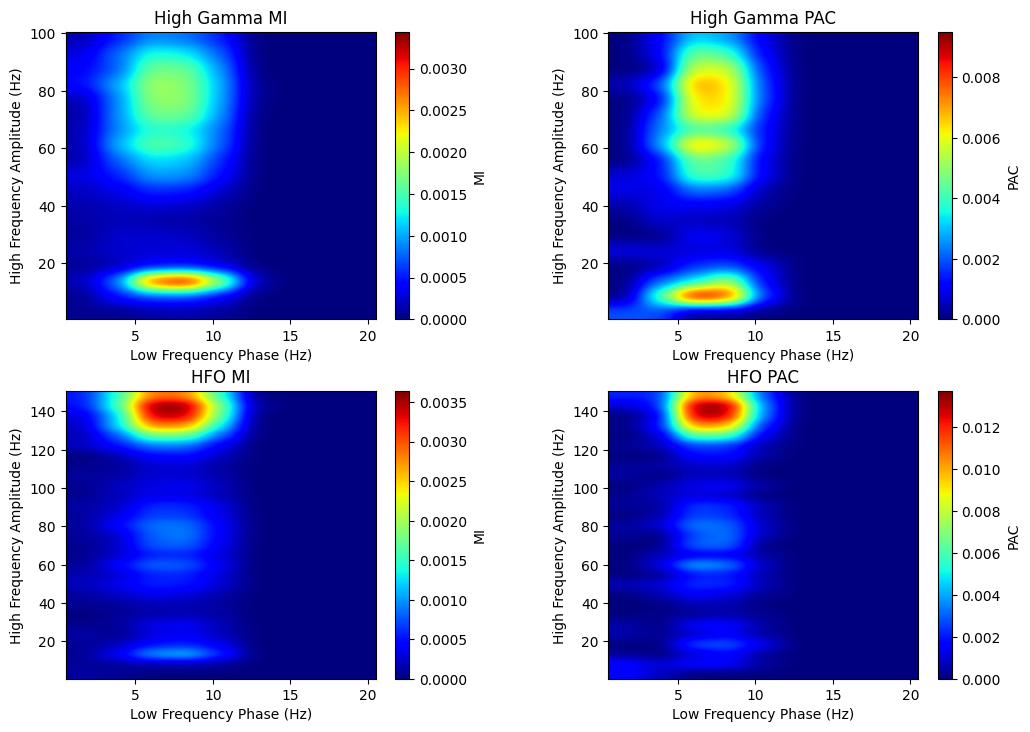

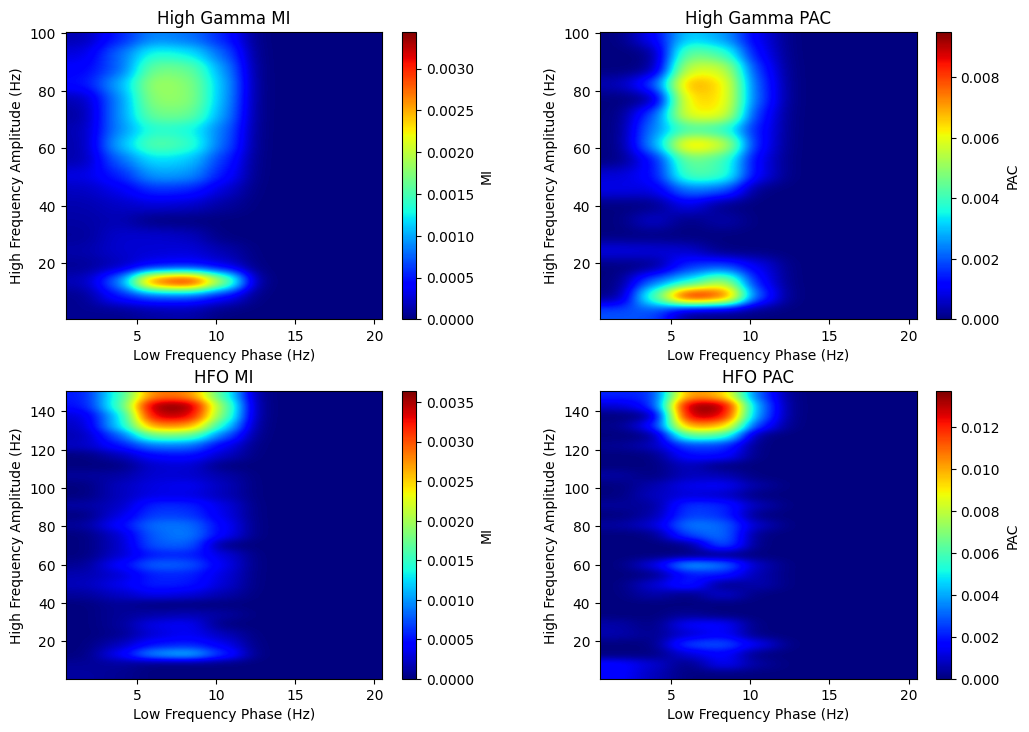

In [28]:
fig,ax = plt.subplots(2,2,figsize=(12,8.4))
ax = ax.flatten()
for i in range(4):
    pvals_holm, bh_idx, k = bh_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = False)
    tmp = np.zeros(comods[i].shape)


    for idx in bh_idx[:k+1]:
        j = idx//comods[i].shape[1]
        k = idx%comods[i].shape[1]
        tmp[j,k] = comods[i].flatten()[idx]
    im = ax[i].imshow(tmp,aspect = 'auto',origin = 'lower',extent =[lband[0],lband[1],hbands[i//2][0],hbands[i//2][1]],interpolation = 'gaussian',cmap = 'jet' )
    ax[i].set_title(names[i])
    print(f'{names[i]}: {np.sum(tmp>0)} significant points')
    #show colorbar
    labels = ['MI','PAC']
    cbar = fig.colorbar(im, ax=ax[i],label = labels[i%2])
    #change wspacing
    fig.subplots_adjust(wspace=.4)
    fig.subplots_adjust(hspace=.25)
    ax[i].set_xlabel('Low Frequency Phase (Hz)')
    ax[i].set_ylabel('High Frequency Amplitude (Hz)')
# plt.savefig('../Figures/comod_bh_sig.svg')

fig,ax = plt.subplots(2,2,figsize=(12,8.4))
ax = ax.flatten()
for i in range(4):
    pvals_holm, holm_idx, k = holm_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = False)
    tmp = np.zeros(comods[i].shape)


    for idx in holm_idx[:k+1]:
        j = idx//comods[i].shape[1]
        k = idx%comods[i].shape[1]
        tmp[j,k] = comods[i].flatten()[idx]
    im = ax[i].imshow(tmp,aspect = 'auto',origin = 'lower',extent =[lband[0],lband[1],hbands[i//2][0],hbands[i//2][1]],interpolation = 'gaussian',cmap = 'jet' )
    ax[i].set_title(names[i])
    print(f'{names[i]}: {np.sum(tmp>0)} significant points')
    #show colorbar
    labels = ['MI','PAC']
    cbar = fig.colorbar(im, ax=ax[i],label = labels[i%2])
    #change wspacing
    fig.subplots_adjust(wspace=.35)
    fig.subplots_adjust(hspace=.25)
    ax[i].set_xlabel('Low Frequency Phase (Hz)')
    ax[i].set_ylabel('High Frequency Amplitude (Hz)')
# plt.savefig('../Figures/comod_holm_sig.svg')